 Segmentation by U-Net: The analysis of retinal blood vessels is useful for the diagnosis and treatment of various cardiovascular diseases
such as diabetes and hypertension. Furthermore, the retinal vascular tree is unique for each individual and can be used
for biometric identification. For the exercise we will use the dataset DRIVE (Digital Retinal Images for
Vessel Extraction) dataset composed of 20 images for training, for more information there is the official site
https://drive.grand-challenge.org/. For each training image a mask is provided that outlines the
field of view (FOV) and a manual segmentation of the blood vessels. An example image
is shown in figure 1.
For convenience we divide the code into three parts: loading and preparation of the data, definition of the architecture and finally training and testing.

In [ ]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from tensorflow import keras

In [ ]:
!echo "check_certificate = off" >> ~/.wgetrc
!wget -q -c https://www.grip.unina.it/download/guide_TF/DRIVE_training.zip
!unzip -q -n DRIVE_training.zip


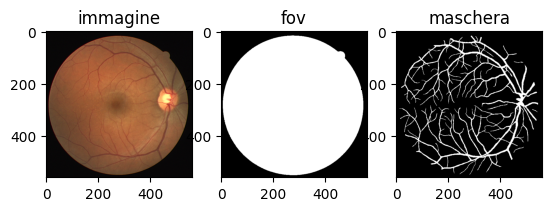

In [ ]:
def read_img(index):
  filename_img = '/content/DRIVE_training/images/img%02d.png'%index  #per mettere l indice 00
  filename_msk = '/content/DRIVE_training/maskes/msk%02d.png'%index
  filename_fov = '/content/DRIVE_training/fov/fov%02d.png'%index

  img = np.float32(io.imread(filename_img))/255
  msk = np.float32(io.imread(filename_msk))/255
  fov = np.float32(io.imread(filename_fov))/255

  return img, fov, msk

index = 15

img, fov, msk = read_img(index)
plt.figure()
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('immagine')
plt.subplot(1,3,2)
plt.imshow(fov, clim=[0,1], cmap='gray')
plt.title('fov')
plt.subplot(1,3,3)
plt.imshow(msk, clim=[0,1], cmap='gray')
plt.title('maschera')
plt.show()



In [ ]:
def estrai_blocchi(index):
  imf, fov, msk =read_img(index)
  M,N,K = img.shape
  list_blocchi_img = list()
  list_blocchi_msk = list()
  for i in range(0, M - 48, 12):
    for j in range(0, N-48, 12):
      block_img = img[i:i+48,j:j+48,:]
      block_fov = fov[i:i+48, j:j+48]
      block_msk = msk[i:i+48, j:j+48]
      if np.mean(block_fov)>0.5:
        list_blocchi_img.append(block_img)
        list_blocchi_msk.append(block_msk)

  list_blocchi_img = np.stack(list_blocchi_img, 0 )
  list_blocchi_msk = np.stack(list_blocchi_msk, 0 )
  return list_blocchi_img, list_blocchi_msk

list_blocchi_img, list_blocchi_msk = estrai_blocchi(1)
print(list_blocchi_img.shape, list_blocchi_msk.shape) #sono matrici che contengono i blocchi estratti dall immagine e dalla maschera


(1540, 48, 48, 3) (1540, 48, 48)


In [ ]:
x_train = list()
y_train = list()
for index in range(16):
  list_blocchi_img, list_blocchi_msk = estrai_blocchi(index)
  x_train.append(list_blocchi_img)
  y_train.append(list_blocchi_msk)
#voglio un unica matrice che contiene tutti i blocchi lungo la prima dimensione quindi devo concatenarli non stak
x_train = np.concatenate(x_train, 0)
y_train = np.concatenate(y_train, 0)
#keras vuole sempre matrici 4 dimensionali anche se lavoriamo a scala di grigi, y train pero non ha la 4 dimensione ma la dobbiamo aggiunere
y_train = np.reshape(y_train, (-1,48,48,1)) #-1 mantiene la dimensione di prima
%whos

Variable           Type        Data/Info
----------------------------------------
estrai_blocchi     function    <function estrai_blocchi at 0x7fe20e9d88b0>
fov                ndarray     560x560: 313600 elems, type `float32`, 1254400 bytes (1.1962890625 Mb)
img                ndarray     560x560x3: 940800 elems, type `float32`, 3763200 bytes (3.5888671875 Mb)
index              int         15
io                 module      <module 'skimage.io' from<...>/skimage/io/__init__.py'>
keras              module      <module 'tensorflow.keras<...>i/_v2/keras/__init__.py'>
list_blocchi_img   ndarray     1542x48x48x3: 10658304 elems, type `float32`, 42633216 bytes (40.658203125 Mb)
list_blocchi_msk   ndarray     1542x48x48: 3552768 elems, type `float32`, 14211072 bytes (13.552734375 Mb)
msk                ndarray     560x560: 313600 elems, type `float32`, 1254400 bytes (1.1962890625 Mb)
np                 module      <module 'numpy' from '/us<...>kages/numpy/__init__.py'>
plt                modu

per la validation dobbiamo fare la stessa cosa


In [ ]:
x_valid = list()
y_valid = list()
for index in range(16, 20):
  list_blocchi_img, list_blocchi_msk = estrai_blocchi(index)
  x_valid.append(list_blocchi_img)
  y_valid.append(list_blocchi_msk)
#voglio un unica matrice che contiene tutti i blocchi lungo la prima dimensione quindi devo concatenarli non stak
x_valid = np.concatenate(x_valid, 0)
y_valid = np.concatenate(y_valid, 0)
#keras vuole sempre matrici 4 dimensionali anche se lavoriamo a scala di grigi, y train pero non ha la 4 dimensione ma la dobbiamo aggiunere
y_valid = np.reshape(y_valid, (-1,48,48,1)) #-1 mantiene la dimensione di prima
%whos

Variable           Type        Data/Info
----------------------------------------
estrai_blocchi     function    <function estrai_blocchi at 0x7fe20e9d88b0>
fov                ndarray     560x560: 313600 elems, type `float32`, 1254400 bytes (1.1962890625 Mb)
img                ndarray     560x560x3: 940800 elems, type `float32`, 3763200 bytes (3.5888671875 Mb)
index              int         19
io                 module      <module 'skimage.io' from<...>/skimage/io/__init__.py'>
keras              module      <module 'tensorflow.keras<...>i/_v2/keras/__init__.py'>
list_blocchi_img   ndarray     1540x48x48x3: 10644480 elems, type `float32`, 42577920 bytes (40.60546875 Mb)
list_blocchi_msk   ndarray     1540x48x48: 3548160 elems, type `float32`, 14192640 bytes (13.53515625 Mb)
msk                ndarray     560x560: 313600 elems, type `float32`, 1254400 bytes (1.1962890625 Mb)
np                 module      <module 'numpy' from '/us<...>kages/numpy/__init__.py'>
plt                module

In [ ]:
from unet import UNet
model = UNet(input_shape=(None, None, 3), num_output=1) #non voglio fissare le dimensioni delle immagini in ingrersso e metto None, num output decido il numeor id canali che voglio, in uscita dalla rete voglio la mschera e metto 1
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_23 (Conv2D)             (None, None, None,   1792        ['input_2[0][0]']                
                                64)                                                               
                                                                                                  
 conv2d_24 (Conv2D)             (None, None, None,   36928       ['conv2d_23[0][0]']              
                                64)                                                         

In [ ]:
from unet import iou_metric , fm_metric

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=['accuracy', iou_metric, fm_metric])
model.fit(x_train, y_train, validation_data=(x_valid, y_valid),
          batch_size = 64, epochs=200, verbose=True)


Epoch 1/200
 29/385 [=>............................] - ETA: 1:08 - loss: 0.4402 - accuracy: 0.8476 - iou_metric: 0.0054 - fm_metric: 0.0096

KeyboardInterrupt: ignored

In [ ]:
!wget -q -c http://www.grip.unina.it/download/guide_TF/weights_unet_retina.hdf5
model.load_weights('weights_unet_retina.hdf5')

1/1 [==============================] - 0s 24ms/step
0.6452549657335347


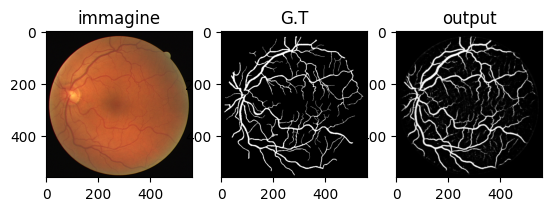

In [ ]:
index = 18
img, fov, msk = read_img(index)
M,N,K = img.shape
img_4d = np.reshape(img, (1,M,N,K))
pred = model.predict(img_4d)
pred = pred[0,:,:,0]

plt.figure()
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('immagine')
plt.subplot(1,3,2)
plt.imshow(msk, clim=[0,1], cmap='gray')
plt.title('G.T')
plt.subplot(1,3,3)
plt.imshow(pred, clim=[0,1], cmap='gray')
plt.title('output')
pred_binaria = pred>0.5
msk=msk>0.5 #per convertirla in binario
iou_value = np.sum(msk & pred_binaria)/np.sum(msk | pred_binaria)
print(iou_value)